# Konformo predviđanje: Nixtla, ARIMA

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from statsforecast.utils import ConformalIntervals

warnings.filterwarnings("ignore")
sns.set_theme()

c:\Users\Duje\Desktop\fer\6. semestar\lumen\Prediction-of-Hotel-Occupancy\.venv\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\Duje\Desktop\fer\6. semestar\lumen\Prediction-of-Hotel-Occupancy\.venv\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'

## Učitavanje podataka

Podatke nakon učitavanja moramo prilagoditi formatu kojeg očekuje `StatsForecast`:
- `unique_id` - jedinstveni identifikator vremenskog niza
- `ds` - ili cijeli broj koji predstavlja vrijeme ili datum kao niz znakova
- `y` - ciljna varijabla koju želimo prognozirati

In [3]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))

NumberOfGuestsDailyResort.rename({"ukupno_gostiju": "y"}, axis="columns", inplace=True)
NumberOfGuestsDailyResort.drop("prosjecna_cijena_po_osobi", axis="columns", inplace=True)
NumberOfGuestsDailyResort.index.rename("ds", inplace=True)
NumberOfGuestsDailyResort["unique_id"] = np.repeat("H0", repeats=len(NumberOfGuestsDailyResort))
NumberOfGuestsDailyResort.reset_index(inplace=True)

NumberOfGuestsDailyCity.rename({"ukupno_gostiju": "y"}, axis="columns", inplace=True)
NumberOfGuestsDailyCity.drop("prosjecna_cijena_po_osobi", axis="columns", inplace=True)
NumberOfGuestsDailyCity.index.rename("ds", inplace=True)
NumberOfGuestsDailyCity["unique_id"] = np.repeat("H1", repeats=len(NumberOfGuestsDailyCity))
NumberOfGuestsDailyCity.reset_index(inplace=True)

In [4]:
resort_split = int(len(NumberOfGuestsDailyResort) * 0.8)
city_split = int(len(NumberOfGuestsDailyCity) * 0.8)

resort_train, resort_test = NumberOfGuestsDailyResort[:resort_split], NumberOfGuestsDailyResort[resort_split:]
city_train, city_test = NumberOfGuestsDailyCity[:city_split], NumberOfGuestsDailyCity[city_split:]


## Prognoza

In [5]:
resort_intervals = ConformalIntervals(h=len(resort_test), n_windows=2)

resort_models = [
    ARIMA(order=(6,1,0), seasonal_order=(6,1,0), season_length=7, prediction_intervals=resort_intervals),
]

resort_sf = StatsForecast(
    df=resort_train,
    models=resort_models,
    freq='D',
)

In [6]:
city_intervals = ConformalIntervals(h=len(city_test), n_windows=2)

city_models = [
    ARIMA(order=(3,1,0), seasonal_order=(6,1,0), season_length=7, prediction_intervals=city_intervals),
]

city_sf = StatsForecast(
    df=city_train,
    models=city_models,
    freq='D',
)

In [7]:
levels = [80, 90]

resort_forecasts = resort_sf.forecast(h=len(resort_test), level=levels)
resort_forecasts = resort_forecasts.reset_index()
resort_forecasts.head()

,unique_id,ds,ARIMA,ARIMA-lo-90,ARIMA-lo-80,ARIMA-hi-80,ARIMA-hi-90
0,H0,2017-04-06,463.578369,430.059082,435.005371,492.151398,497.097687
1,H0,2017-04-07,405.168793,367.401001,369.231812,441.105774,442.936584
2,H0,2017-04-08,463.959625,357.054993,364.943573,562.975647,570.864258
3,H0,2017-04-09,470.243164,357.354065,369.217377,571.268921,583.132263
4,H0,2017-04-10,396.233063,302.873566,308.487518,483.978607,489.592560


In [8]:
city_forecasts = city_sf.forecast(h=len(city_test), level=levels)
city_forecasts = city_forecasts.reset_index()
city_forecasts.head()

,unique_id,ds,ARIMA,ARIMA-lo-90,ARIMA-lo-80,ARIMA-hi-80,ARIMA-hi-90
0,H1,2017-06-09,475.135468,461.657410,462.587952,487.683014,488.613525
1,H1,2017-06-10,451.503693,424.009247,426.963593,476.043793,478.998169
2,H1,2017-06-11,438.770874,356.689056,360.503326,517.038391,520.852661
3,H1,2017-06-12,435.659607,392.486725,398.929779,472.389404,478.832458
4,H1,2017-06-13,427.274933,403.507751,404.065216,450.484650,451.042114


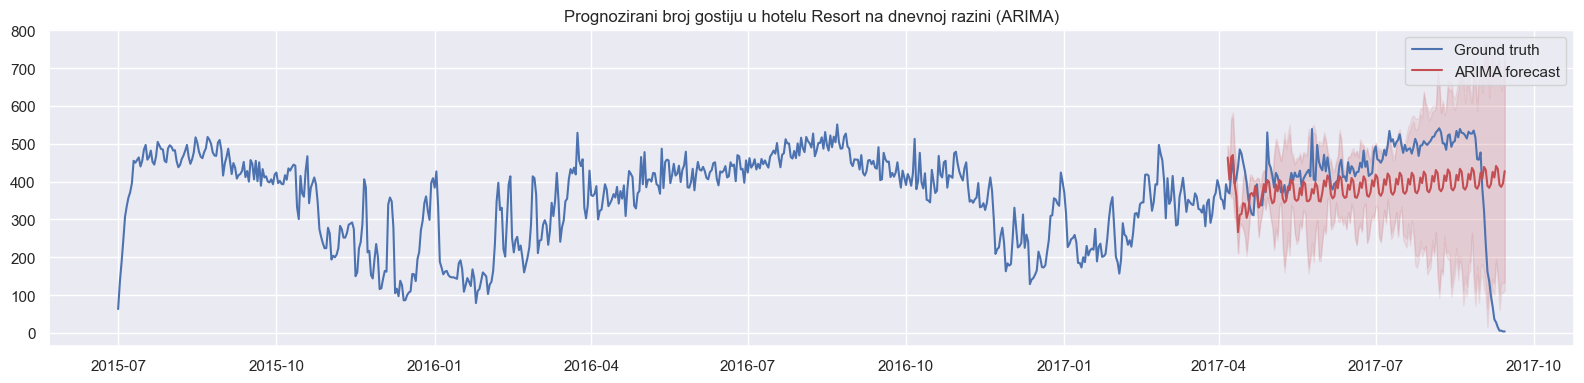

In [9]:
plt.figure(figsize=(16,4))

plt.plot(NumberOfGuestsDailyResort["ds"], NumberOfGuestsDailyResort["y"], label="Ground truth", color="b")
plt.plot(resort_forecasts["ds"], resort_forecasts["ARIMA"], label="ARIMA forecast", color="r")
plt.fill_between(resort_forecasts["ds"], resort_forecasts["ARIMA-lo-80"], resort_forecasts["ARIMA-hi-80"], alpha=0.1, color="r")
plt.fill_between(resort_forecasts["ds"], resort_forecasts["ARIMA-lo-90"], resort_forecasts["ARIMA-hi-90"], alpha=0.1, color="r")

plt.title("Prognozirani broj gostiju u hotelu Resort na dnevnoj razini (ARIMA)")
plt.tight_layout()
plt.legend()

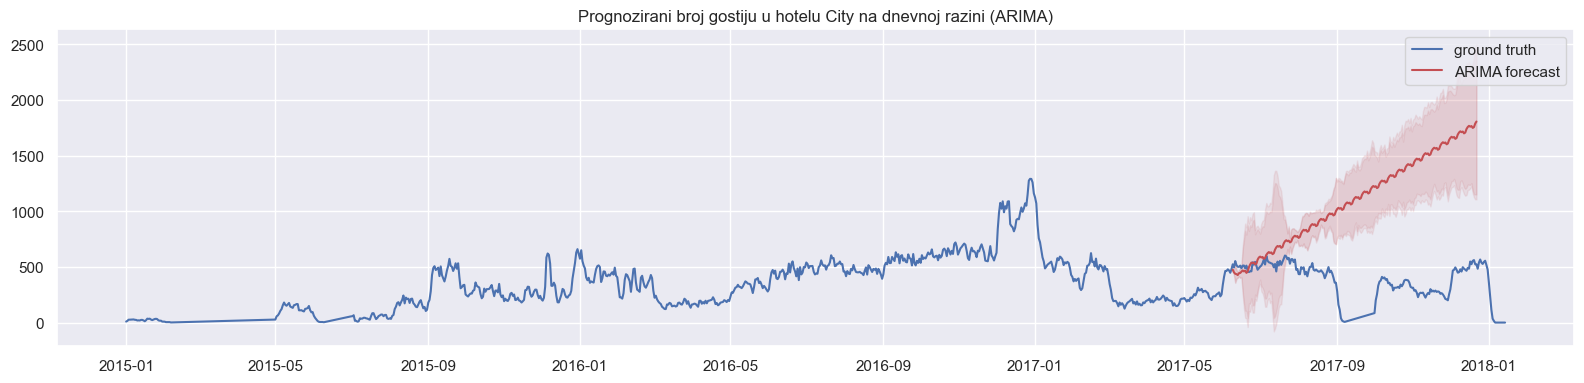

In [10]:
plt.figure(figsize=(16,4))
plt.plot(NumberOfGuestsDailyCity["ds"], NumberOfGuestsDailyCity["y"], label="ground truth", color="b")
plt.plot(city_forecasts["ds"], city_forecasts["ARIMA"], label="ARIMA forecast", color="r")
plt.fill_between(city_forecasts["ds"], city_forecasts["ARIMA-lo-80"], city_forecasts["ARIMA-hi-80"], alpha=0.1, color="r")
plt.fill_between(city_forecasts["ds"], city_forecasts["ARIMA-lo-90"], city_forecasts["ARIMA-hi-90"], alpha=0.1, color="r")

plt.title("Prognozirani broj gostiju u hotelu City na dnevnoj razini (ARIMA)")
plt.tight_layout()
plt.legend()